# Lab 8: Optical Flow (40 Pts)


## Important:
We have updated the conda environment for the class. Please download the new `env-mae345.yml` file and follow the instructions under "Install Instructions" in the README. To activate the new conda env, enter the command `conda activate mae345-py37`. 

## Lab Instructions:
In this lab, we are going to implement the optical flow algorithm we discussed in class. Optical flow is a very useful algorithm for a wide variety of robotics tasks, including state estimation, tracking objects, and dynamically avoiding obstacles. It's also very straightforward to implement. 

Also, you should be aware that a couple of the cells in this notebook render videos. While designing the assignment, the instructors found that Jupyter continues to store previous videos in memory if you rerun the cell multiple times. As a result, your computer may run out of RAM if you run the cell too many times. If this does occur, you can kill the Jupyter process in the terminal by pulling up the terminal window running Jupyter and hitting `Ctrl+C`.

In addition, some times the rendered gifs might not update when you make a change to your code. If you think this occurs, restart the kernel (using the button next to the stop button) and delete the gif on your hard drive. That will force Jupyter to load a fresh gif when you run the cell.

Let's start by capturing a video with your JetBot. First, load `takevideo_jetbot.ipynb` onto your JetBot and follow the instructions in the notebook for capturing a good video. Once you have your own `video_jetbot.avi`, save the file in the same directory as `Lab8.ipynb` on your computer and proceed. (Note that we complete this lab on the computer rather than the JetBot as it is fairly computationally intensive.) We will also load a sample video that's provided to you. The purpose of the sample video is to simplify debugging, since everyone will have the same sample.

In [1]:
import numpy as np
import cv2
import time
from IPython.display import HTML, Image

from matplotlib import pyplot as plt
from matplotlib import animation
from typing import List, Tuple

%matplotlib inline 

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

cap_jetbot = cv2.VideoCapture('video_jetbot.avi')
cap_sample = cv2.VideoCapture('video_sample.avi')
fps = cap_jetbot.get(cv2.CAP_PROP_FPS)
dt = 1 / fps
image_size = (480, 270)


frames = []

while cap_jetbot.isOpened():
    ret, frame = cap_jetbot.read()
    
    if ret == False:
        break
    else:
        frames.append(frame)

cap_jetbot.release()


I_jetbot = np.zeros([image_size[1], image_size[0], len(frames)])


for t in range(len(frames)):
    I_jetbot[:, :, t] = cv2.cvtColor(cv2.resize(frames[t], image_size), cv2.COLOR_BGR2GRAY) / 255
    
frames = []

while cap_sample.isOpened():
    ret, frame = cap_sample.read()
    
    if ret == False:
        break
    else:
        frames.append(frame)

cap_sample.release()


I_sample = np.zeros([image_size[1], image_size[0], len(frames)])


for t in range(len(frames)):
    I_sample[:, :, t] = cv2.cvtColor(cv2.resize(frames[t], image_size), cv2.COLOR_BGR2GRAY) / 255

The variable `I` now contains a grayscale video represented as a numpy array. How videos are represented in numpy is as a three dimensional array. If you want to access the pixel at $(x, y)$ at time $t$, it is stored at `I[y, x, t]`. Moreover, all values in `I` are between 0 (black) and 1 (white).

We can take a look at the video in motion:

## Jetbot

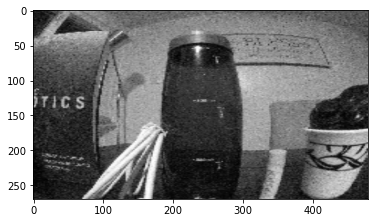

In [2]:
fig, ax = plt.subplots()

im = ax.imshow(I_jetbot[:, :, 0], cmap='gray')

def init():
    return [im]

def animate(i):
    im.set_data(I_jetbot[:, :, i])

    return [im]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=I_jetbot.shape[2], interval=20, blit=True)

anim.save('./anim-jetbot.gif', writer='pillow', fps=100)
Image(url='./anim-jetbot.gif')

## Sample 

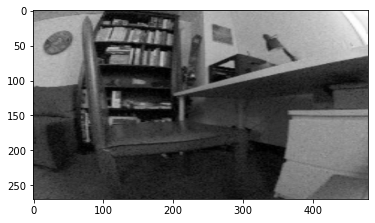

In [3]:
fig, ax = plt.subplots()

im = ax.imshow(I_sample[:, :, 0], cmap='gray')

def init():
    return [im]

def animate(i):
    im.set_data(I_sample[:, :, i])

    return [im]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=I_sample.shape[2], interval=20, blit=True)

anim.save('./anim-sample.gif', writer='pillow', fps=100)
Image(url='./anim-sample.gif')

Now, we can start processing the images. Your job below is to implement the optical flow algorithm discussed in class. For a single point, $(x, y)$, the window size $w$ is the side length of the box around the pixel. That is define $h = \mathrm{floor}(w / 2)$, then the window is the set of pixels $\{(x', y')\ |\ x - h \leq x' \leq x + h, y - h\leq 'y \leq y + h\}$.

You'll also need to take a number of image derivatives. [There are a lot of ways](https://en.wikipedia.org/wiki/Image_derivatives) one can go about taking them. We'll keep it simple, however, and say that the spatial derivatives $I_x, I_y$ at $(x, y)$ can be computed by subtracting the value at $(x, y)$ from $(x + 1, y + 1)$. For the temporal derivative $I_t$, you can subtract the previous image from the current one.

Using the algorithm as described so far, we'll run into trouble around the border of the image, as there are not enough pixels to create a window or potentially even take a derivative. To handle these cases, we will do the following:

1. Take the image derivatives first. Throw out all pixels for which they are not defined.

2. Create as large a window as possible around the target pixel $(x, y)$. If there are not enough pixels for a complete window, use all the pixels available in the region.

Also, in class, it was discussed that there are cases where the matrix:

$$A^{\mathrm{T}}A = \begin{bmatrix}\sum I_x I_x & \sum I_x I_y\\ \sum I_y I_x & \sum I_y I_y\end{bmatrix}$$

is not invertible. In practice, the determinant of $A^{\mathrm{T}}A$ is unlikely to be exactly zero due to the numerical approximations the computer makes. It may, however, be very small. Since we are solving for two unknowns $u, v$, we need the rank of this matrix to be at least 2. Therefore, we need at least two of the eigenvalues of $A^{\mathrm{T}}A$ to be of a reasonable size. After computing $A$, you should only solve the least-squares problem for $u, v$ if at least two eigenvalues are larger than $0.001$. Otherwise just set $u, v$ to be zero for the point at which you are evaluating the optical flow. You can compute the eigenvalues with Numpy's [eigvals](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigvals.html) function.

Be sure you are using the correct coordinates when accessing the image. It is a common pitfall.

In [7]:
def optical_flow(prev_image: np.ndarray, image: np.ndarray, pts: np.ndarray, win_size: int) -> np.ndarray:
    """
    Compute the optical flow between two images using the Lucas-Kanade algorithm.
    
    @param prev_image: The image at time t - 1. Images are represented as arrays of the form I[y, x, t]
                       and are grayscale.
    @param image: The image at time t.
    @param pts: An n-by-2 array of points at which to evaluate the optical flow. Each point is
                 of the form [x, y].
    @param win_size: The size of the window used to compute the flow.
    
    @return: An n-by-2 array whose ith row contains the optical flow at the ith row in pts.
    """
    h = int(np.floor(win_size/2))
    num_pts = pts.shape[0]
    
    It = image - prev_image
    
    Ix = np.zeros(image.shape)   #for the x derivative at all locations
    Iy = np.zeros(image.shape)   #for the y derivatives at all locations
   
    
    #A matrix for each point in pts. Stores [Ix, Iy] for each point in the window, n times
    A_points = np.zeros((win_size**2,2,num_pts))
    
    #b matrix for each point in pts. Stores [It] for each point in the window, n times
    b_points = np.zeros((win_size**2,1,num_pts))
    
    #d points for each point in pts. Stores 
    d_points = np.zeros((2,num_pts))
    
    
    for i in range(len(pts)):  #for every point in the pts array
        x_ind = int(pts[i,0])
        y_ind = int(pts[i,1])
        
        x_lower = max(0,x_ind-h)
        x_upper = min(x_ind+h,image.shape[1])
        
        y_lower = max(0,y_ind-h)
        y_upper = min(y_ind+h,image.shape[0])
        
        #this essentially just ignores the last ring for the purposes of assigning vectors
        for j in range(image.shape[1]-1):
            for k in range(image.shape[0]-1): 
                Ix[k,j] = image[k,j+1] - image[k,j] 
                Iy[k,j] = image[k+1,j] - image[k,j]
                    
        p = 0
        for j in range(x_lower,x_upper):
            for k in range(y_lower, y_upper):
                if ((It[k,j]) and (Ix[k,j]) and (Iy[k,j])): #checks if the derivatives are None
                    b_points[p,0,i] = -It[k,j]
                    A_points[p,0,i] = Ix[k,j]
                    A_points[p,1,i] = Iy[k,j]
                p+=1
        
        #print(A_points)
        AtA = A_points[:,:,i].T@A_points[:,:,i]
        try:
            evals = np.linalg.eigvals(AtA)
        except np.linalg.LinAlgError:
            print(A_points)
            print('stopping the function because there were infs or nans')
            return
            
        if ((evals[0] >0.001 ) and (evals[1] > 0.001)):
            d_points[:,i] = np.linalg.inv(AtA)@A_points[:,:,i].T@b_points[:,0,i]
        else:
            d_points[:,i] = [0,0]
        
    return d_points[:,0]

Now lets apply it to the image. This may take some time to run. In practice, optical flow can be computed extremely quickly, but our code is slow for pedagogical purposes. If you want to just test your code quickly, change the value of `horizon` to some small value like 10. Be sure to change it back before submission, though. You can also play with the `window_size` variable to see how it impacts the computed flow. Please submit your notebook with `window_size = 15` (the default).

## Jetbot

In [13]:
I = I_jetbot

print(I[:,:,0])
print(I[1,1,0].shape)

window_size = 15
horizon = I.shape[2]

# Compute the optical flow at each point.
flow = np.zeros((I.shape[0] - 1, I.shape[1] - 1, I.shape[2] - 1, 2))

for t in range(1, horizon):
    if t % 10 == 0:
        print('Completed {0} frames.'.format(t))
        
    for j in range(0, flow.shape[0], 25):
        for i in range(0, flow.shape[1], 25):
            flow[j, i, t - 1] = optical_flow(I[:, :, t - 1], I[:, :, t], np.array([[i, j]]).astype(float), window_size)

mean_flow = np.zeros((flow.shape[2], 2))

# Compute the mean flow at each time step.
for t in range(mean_flow.shape[0]):
    mean_flow[t, 0] = flow[:, :, t, 0].mean()
    mean_flow[t, 1] = flow[:, :, t, 1].mean()
    
plt.plot(np.arange(0, mean_flow.shape[0] * dt, dt), mean_flow[:, 0], label='X Mean')
plt.plot(np.arange(0, mean_flow.shape[0] * dt, dt), mean_flow[:, 1], label='Y Mean')
plt.legend()

[[0.28627451 0.24705882 0.16078431 ... 0.35294118 0.37647059 0.38431373]
 [0.17647059 0.16078431 0.11372549 ... 0.45490196 0.44313725 0.43921569]
 [0.12156863 0.1254902  0.1372549  ... 0.41568627 0.41960784 0.41960784]
 ...
 [0.09019608 0.08235294 0.07058824 ... 0.2627451  0.28627451 0.29803922]
 [0.12156863 0.12156863 0.12156863 ... 0.23137255 0.2627451  0.27843137]
 [0.12941176 0.14509804 0.17647059 ... 0.23137255 0.27843137 0.29803922]]
()


"\nwindow_size = 15\nhorizon = I.shape[2]\n\n# Compute the optical flow at each point.\nflow = np.zeros((I.shape[0] - 1, I.shape[1] - 1, I.shape[2] - 1, 2))\n\nfor t in range(1, horizon):\n    if t % 10 == 0:\n        print('Completed {0} frames.'.format(t))\n        \n    for j in range(0, flow.shape[0], 25):\n        for i in range(0, flow.shape[1], 25):\n            flow[j, i, t - 1] = optical_flow(I[:, :, t - 1], I[:, :, t], np.array([[i, j]]).astype(float), window_size)\n\nmean_flow = np.zeros((flow.shape[2], 2))\n\n# Compute the mean flow at each time step.\nfor t in range(mean_flow.shape[0]):\n    mean_flow[t, 0] = flow[:, :, t, 0].mean()\n    mean_flow[t, 1] = flow[:, :, t, 1].mean()\n    \nplt.plot(np.arange(0, mean_flow.shape[0] * dt, dt), mean_flow[:, 0], label='X Mean')\nplt.plot(np.arange(0, mean_flow.shape[0] * dt, dt), mean_flow[:, 1], label='Y Mean')\nplt.legend()"

## Sample

Completed 10 frames.
Completed 20 frames.
Completed 30 frames.
Completed 40 frames.
Completed 50 frames.
Completed 60 frames.
This took 1484.2825558185577 seconds


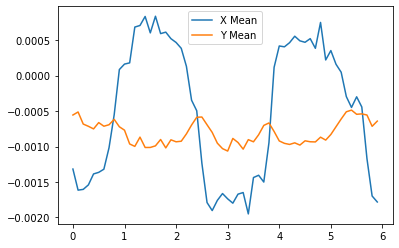

In [11]:
import time

start = time.time()
I = I_sample

window_size = 15
horizon = I.shape[2]

# Compute the optical flow at each point.
flow = np.zeros((I.shape[0] - 1, I.shape[1] - 1, I.shape[2] - 1, 2))

for t in range(1, horizon):
    if t % 10 == 0:
        print('Completed {0} frames.'.format(t))
        
    for j in range(0, flow.shape[0], 25):
        for i in range(0, flow.shape[1], 25):
            flow[j, i, t - 1] = optical_flow(I[:, :, t - 1], I[:, :, t], np.array([[i, j]]).astype(float), window_size)

mean_flow = np.zeros((flow.shape[2], 2))

# Compute the mean flow at each time step.
for t in range(mean_flow.shape[0]):
    mean_flow[t, 0] = flow[:, :, t, 0].mean()
    mean_flow[t, 1] = flow[:, :, t, 1].mean()

end = time.time()
print('This took {} seconds'.format(end-start))
plt.plot(np.arange(0, mean_flow.shape[0] * dt, dt), mean_flow[:, 0], label='X Mean')
plt.plot(np.arange(0, mean_flow.shape[0] * dt, dt), mean_flow[:, 1], label='Y Mean')
plt.legend()

Finally, we'll plot some of the optical flow values on top of the video itself. If you implemented things correctly, there should be a few trends you can observe in the video:
1. Arrows should generally be pointing up when the camera rotates up and pointing down when the camera rotates down.

2. When the camera moves forward (what is known as a "dolly in" motion), the arrows should generally be pointing radially outward. When the camera moves back ("dolly out"), the arrows should generally move radially backward.

3. The white walls should have very small / no arrows, as there are no trackable flow features in those regions.

These phenomena may not appear perfectly. Since the video was filmed by hand, there is some amount of shakiness that contributes to the optical flow. You can also play around with the window size to see whether or not there is improvement.

## Jetbot

In [ ]:
I = I_jetbot
horizon = I.shape[2]

fig, ax = plt.subplots()

cI = np.zeros((I.shape[0], I.shape[1], 3, I.shape[2]))

for t in range(I.shape[2]):
    cI[:, :, :, t] = cv2.cvtColor((I[:, :, t] * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB).astype(float) / 255

im = ax.imshow(cI[:, :, :, 0])

num_arrows = len(range(0, flow.shape[0], 25)) * len(range(0, flow.shape[1], 25))

cx = np.zeros(num_arrows)
cy = np.zeros(num_arrows)
u = np.zeros(num_arrows)
v = np.zeros(num_arrows)

k = 0
    
for j in range(0, flow.shape[0], 25):
    for i in range(0, flow.shape[1], 25):
        cy[k] = j
        cx[k] = i
        u[k] = 0.1
        v[k] = 0.1
        k += 1   

quiv = ax.quiver(cx, cy, u, v, color='r')

def init():
    return [im, quiv]

def animate(t, window_size):
    boxes = []
    y_windows = int(I.shape[0] / window_size)
    x_windows = int(I.shape[1] / window_size)
    
    cx = np.zeros(num_arrows)
    cy = np.zeros(num_arrows)
    u = np.zeros(num_arrows)
    v = np.zeros(num_arrows)
    
    k = 0
    
    for j in range(0, flow.shape[0], 25):
        for i in range(0, flow.shape[1], 25):
            cy[k] = j
            cx[k] = i
            
            if np.linalg.norm(flow[j, i, t, :]) > 0.0001:
                u[k] = 0.1 * flow[j, i, t, 0] / np.linalg.norm(flow[j, i, t, :])
                v[k] = 0.1 * flow[j, i, t, 1] / np.linalg.norm(flow[j, i, t, :])
            else:
                u[k] = 0
                v[k] = 0
            k += 1
    
    im.set_data(cI[:, :, :, t])
    quiv.set_UVC(u, v)

    return [im, quiv]

anim = animation.FuncAnimation(fig, lambda t: animate(t, window_size), init_func=init, frames=(horizon - 2), interval=100, blit=True)

anim.save('./anim-jetbot2.gif', writer='pillow', fps=100)
Image(url='./anim-jetbot2.gif')

## Sample

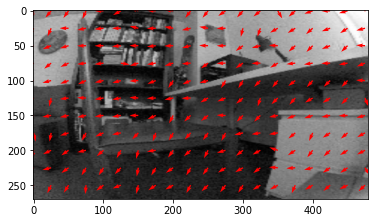

In [12]:
I = I_sample
horizon = I.shape[2]

fig, ax = plt.subplots()

cI = np.zeros((I.shape[0], I.shape[1], 3, I.shape[2]))

for t in range(I.shape[2]):
    cI[:, :, :, t] = cv2.cvtColor((I[:, :, t] * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB).astype(float) / 255

im = ax.imshow(cI[:, :, :, 0])

num_arrows = len(range(0, flow.shape[0], 25)) * len(range(0, flow.shape[1], 25))

cx = np.zeros(num_arrows)
cy = np.zeros(num_arrows)
u = np.zeros(num_arrows)
v = np.zeros(num_arrows)

k = 0
    
for j in range(0, flow.shape[0], 25):
    for i in range(0, flow.shape[1], 25):
        cy[k] = j
        cx[k] = i
        u[k] = 0.1
        v[k] = 0.1
        k += 1   

quiv = ax.quiver(cx, cy, u, v, color='r')

def init():
    return [im, quiv]

def animate(t, window_size):
    boxes = []
    y_windows = int(I.shape[0] / window_size)
    x_windows = int(I.shape[1] / window_size)
    
    cx = np.zeros(num_arrows)
    cy = np.zeros(num_arrows)
    u = np.zeros(num_arrows)
    v = np.zeros(num_arrows)
    
    k = 0
    
    for j in range(0, flow.shape[0], 25):
        for i in range(0, flow.shape[1], 25):
            cy[k] = j
            cx[k] = i
            
            if np.linalg.norm(flow[j, i, t, :]) > 0.0001:
                u[k] = 0.1 * flow[j, i, t, 0] / np.linalg.norm(flow[j, i, t, :])
                v[k] = 0.1 * flow[j, i, t, 1] / np.linalg.norm(flow[j, i, t, :])
            else:
                u[k] = 0
                v[k] = 0
            k += 1
    
    im.set_data(cI[:, :, :, t])
    quiv.set_UVC(u, v)

    return [im, quiv]

anim = animation.FuncAnimation(fig, lambda t: animate(t, window_size), init_func=init, frames=(horizon - 2), interval=100, blit=True)

anim.save('./anim-sample2.gif', writer='pillow', fps=100)
Image(url='./anim-sample2.gif')

# Submission Instructions

As usual, you can submit your completed notebook [here](https://www.dropbox.com/request/eGevdSW6Ik0nMiXPDcfl).